In [105]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers

# Read csv

In [106]:
#read the csv
#column Breed shows the y with the image name
data_csv = pd.read_csv('dataset_CV.csv')
data_csv.head()

DogId           Breed                                     Image  \
0   6673  SIBERIAN HUSKY  4d924d95-de4c-43c0-a586-9fb19cadf905.jpg   
1   6673  SIBERIAN HUSKY  851cc9ee-fc4d-430c-99f6-6425b8bbbe6b.jpg   
2   6673  SIBERIAN HUSKY  7d055dfa-dc6f-4f2b-a7be-dc8bc666836f.jpg   
3   6673  SIBERIAN HUSKY  f1f55f0a-c3d6-442b-b686-71b83b510dc5.jpg   
4   6671  SIBERIAN HUSKY  a2e49a61-7c6a-46f0-a80e-9f32e596c1df.jpg   

   ImageNumber  
0            1  
1            2  
2            3  
3            4  
4            1

In [107]:
data_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4144 entries, 0 to 4143
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   DogId        4144 non-null   int64 
 1   Breed        4144 non-null   object
 2   Image        4144 non-null   object
 3   ImageNumber  4144 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 129.6+ KB


# Preprocessing

In [108]:
data_dir = r"image_classes"

### Create a dataset
Define some parameters for the loader:

In [109]:
batch_size = 32
img_height = 180
img_width = 180

In [110]:
train_test_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4144 files belonging to 5 classes.
Using 3730 files for training.


In [111]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.1,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4144 files belonging to 5 classes.
Using 414 files for validation.


In [112]:
split_ratio = 0.8
train_size = int(split_ratio * len(train_test_ds))
train_ds = train_test_ds.take(train_size)
test_ds = train_test_ds.skip(train_size)

In [113]:
class_names = val_ds.class_names
print(class_names)

['AMERICAN STAFFORDSHIRE BULL TERRIER', 'BORDER COLLIE', 'BULL ARAB', 'GERMAN SHEPHERD', 'SIBERIAN HUSKY']


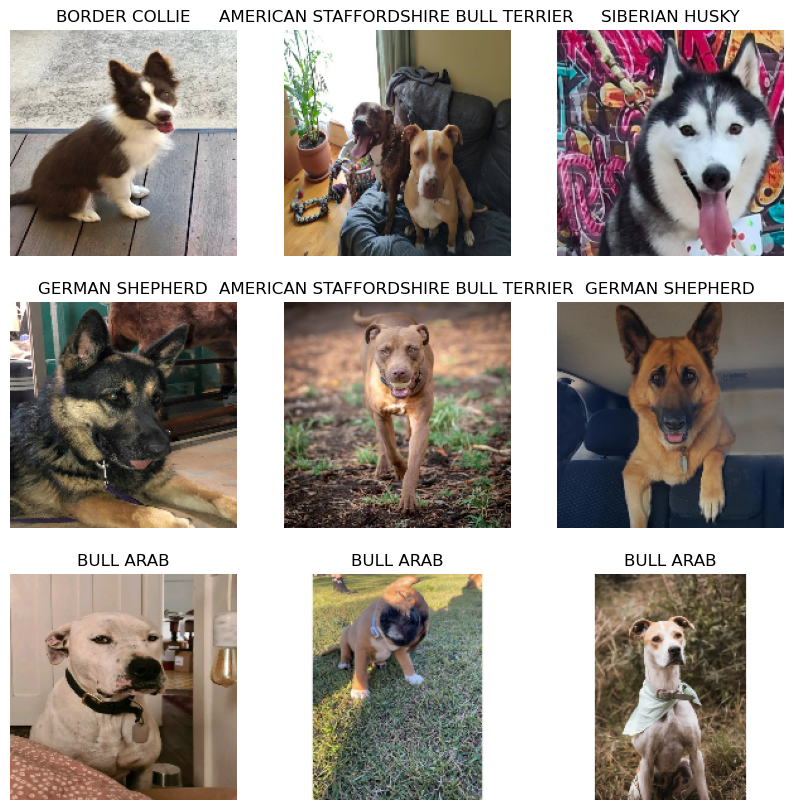

In [114]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [115]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 180, 180, 3)
(32,)


In [116]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Data Augmentation

In [117]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal", input_shape=(img_height, img_width, 3)),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.1),
    ]
)

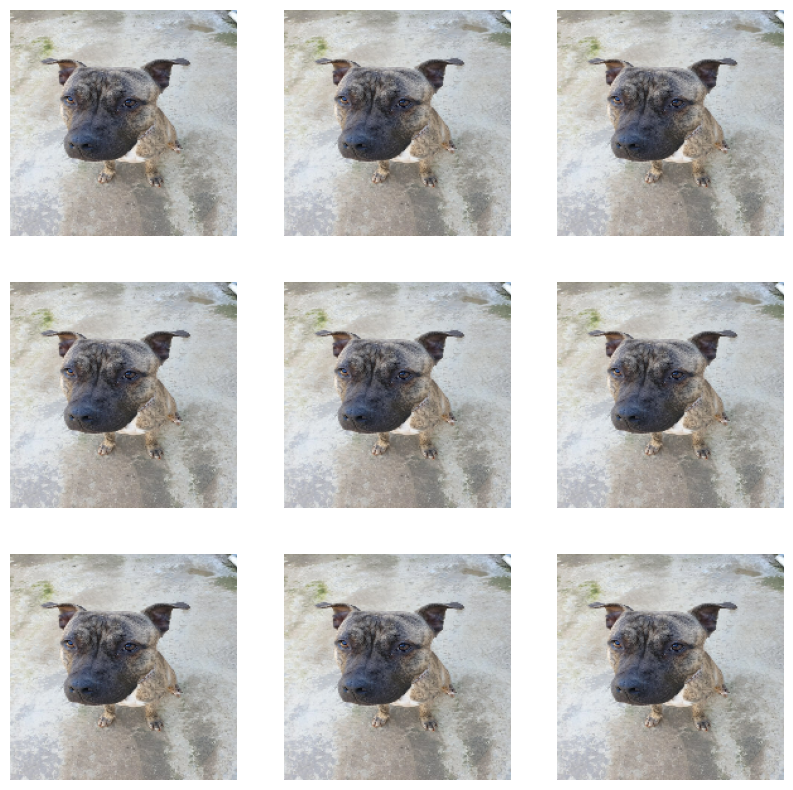

In [118]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Define cnn model

In [119]:
num_classes = len(class_names)

model = Sequential([
    data_augmentation,
    layers.Rescaling(1. / 255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, name="outputs")
])

In [120]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_5 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 90, 90, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 45, 45, 32)       0         
 g2D)                                                

# Training

In [121]:
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/15
93/93 [==============================] - 31s 305ms/step - loss: 1.6198 - accuracy: 0.2352 - val_loss: 1.5328 - val_accuracy: 0.2874
Epoch 2/15
93/93 [==============================] - 27s 287ms/step - loss: 1.4910 - accuracy: 0.3444 - val_loss: 1.4363 - val_accuracy: 0.3768
Epoch 3/15
93/93 [==============================] - 26s 283ms/step - loss: 1.4158 - accuracy: 0.4059 - val_loss: 1.4512 - val_accuracy: 0.3961
Epoch 4/15
93/93 [==============================] - 29s 307ms/step - loss: 1.3416 - accuracy: 0.4358 - val_loss: 1.4047 - val_accuracy: 0.4565
Epoch 5/15
93/93 [==============================] - 27s 290ms/step - loss: 1.2881 - accuracy: 0.4738 - val_loss: 1.3092 - val_accuracy: 0.4565
Epoch 6/15
93/93 [==============================] - 27s 290ms/step - loss: 1.2460 - accuracy: 0.4950 - val_loss: 1.3018 - val_accuracy: 0.4710
Epoch 7/15
93/93 [==============================] - 29s 313ms/step - loss: 1.1837 - accuracy: 0.5265 - val_loss: 1.3059 - val_accuracy: 0.4758

# Plotting

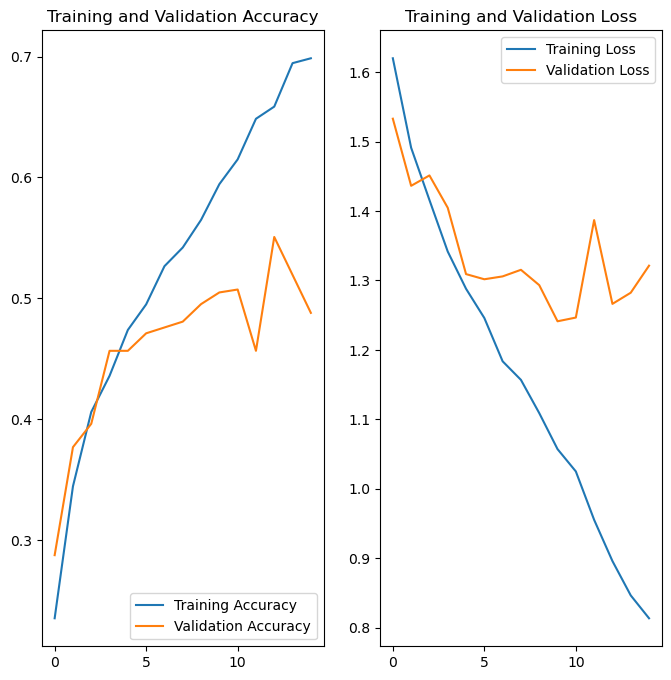

In [122]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Evaluating

In [153]:
print(model.evaluate(test_ds))

24/24 [==============================] - 5s 104ms/step - loss: 1.3444 - accuracy: 0.4814
[1.3444174528121948, 0.48143234848976135]


In [202]:
def plot_image(prediction, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img.numpy().astype("uint8"), cmap=plt.cm.binary)
    predicted_label = class_names[np.argmax(prediction)]
    if predicted_label == class_names[true_label]:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(predicted_label,
                                         100 * np.max(prediction),
                                         class_names[true_label]),
               color=color)

1/1 [==============================] - 0s 78ms/step


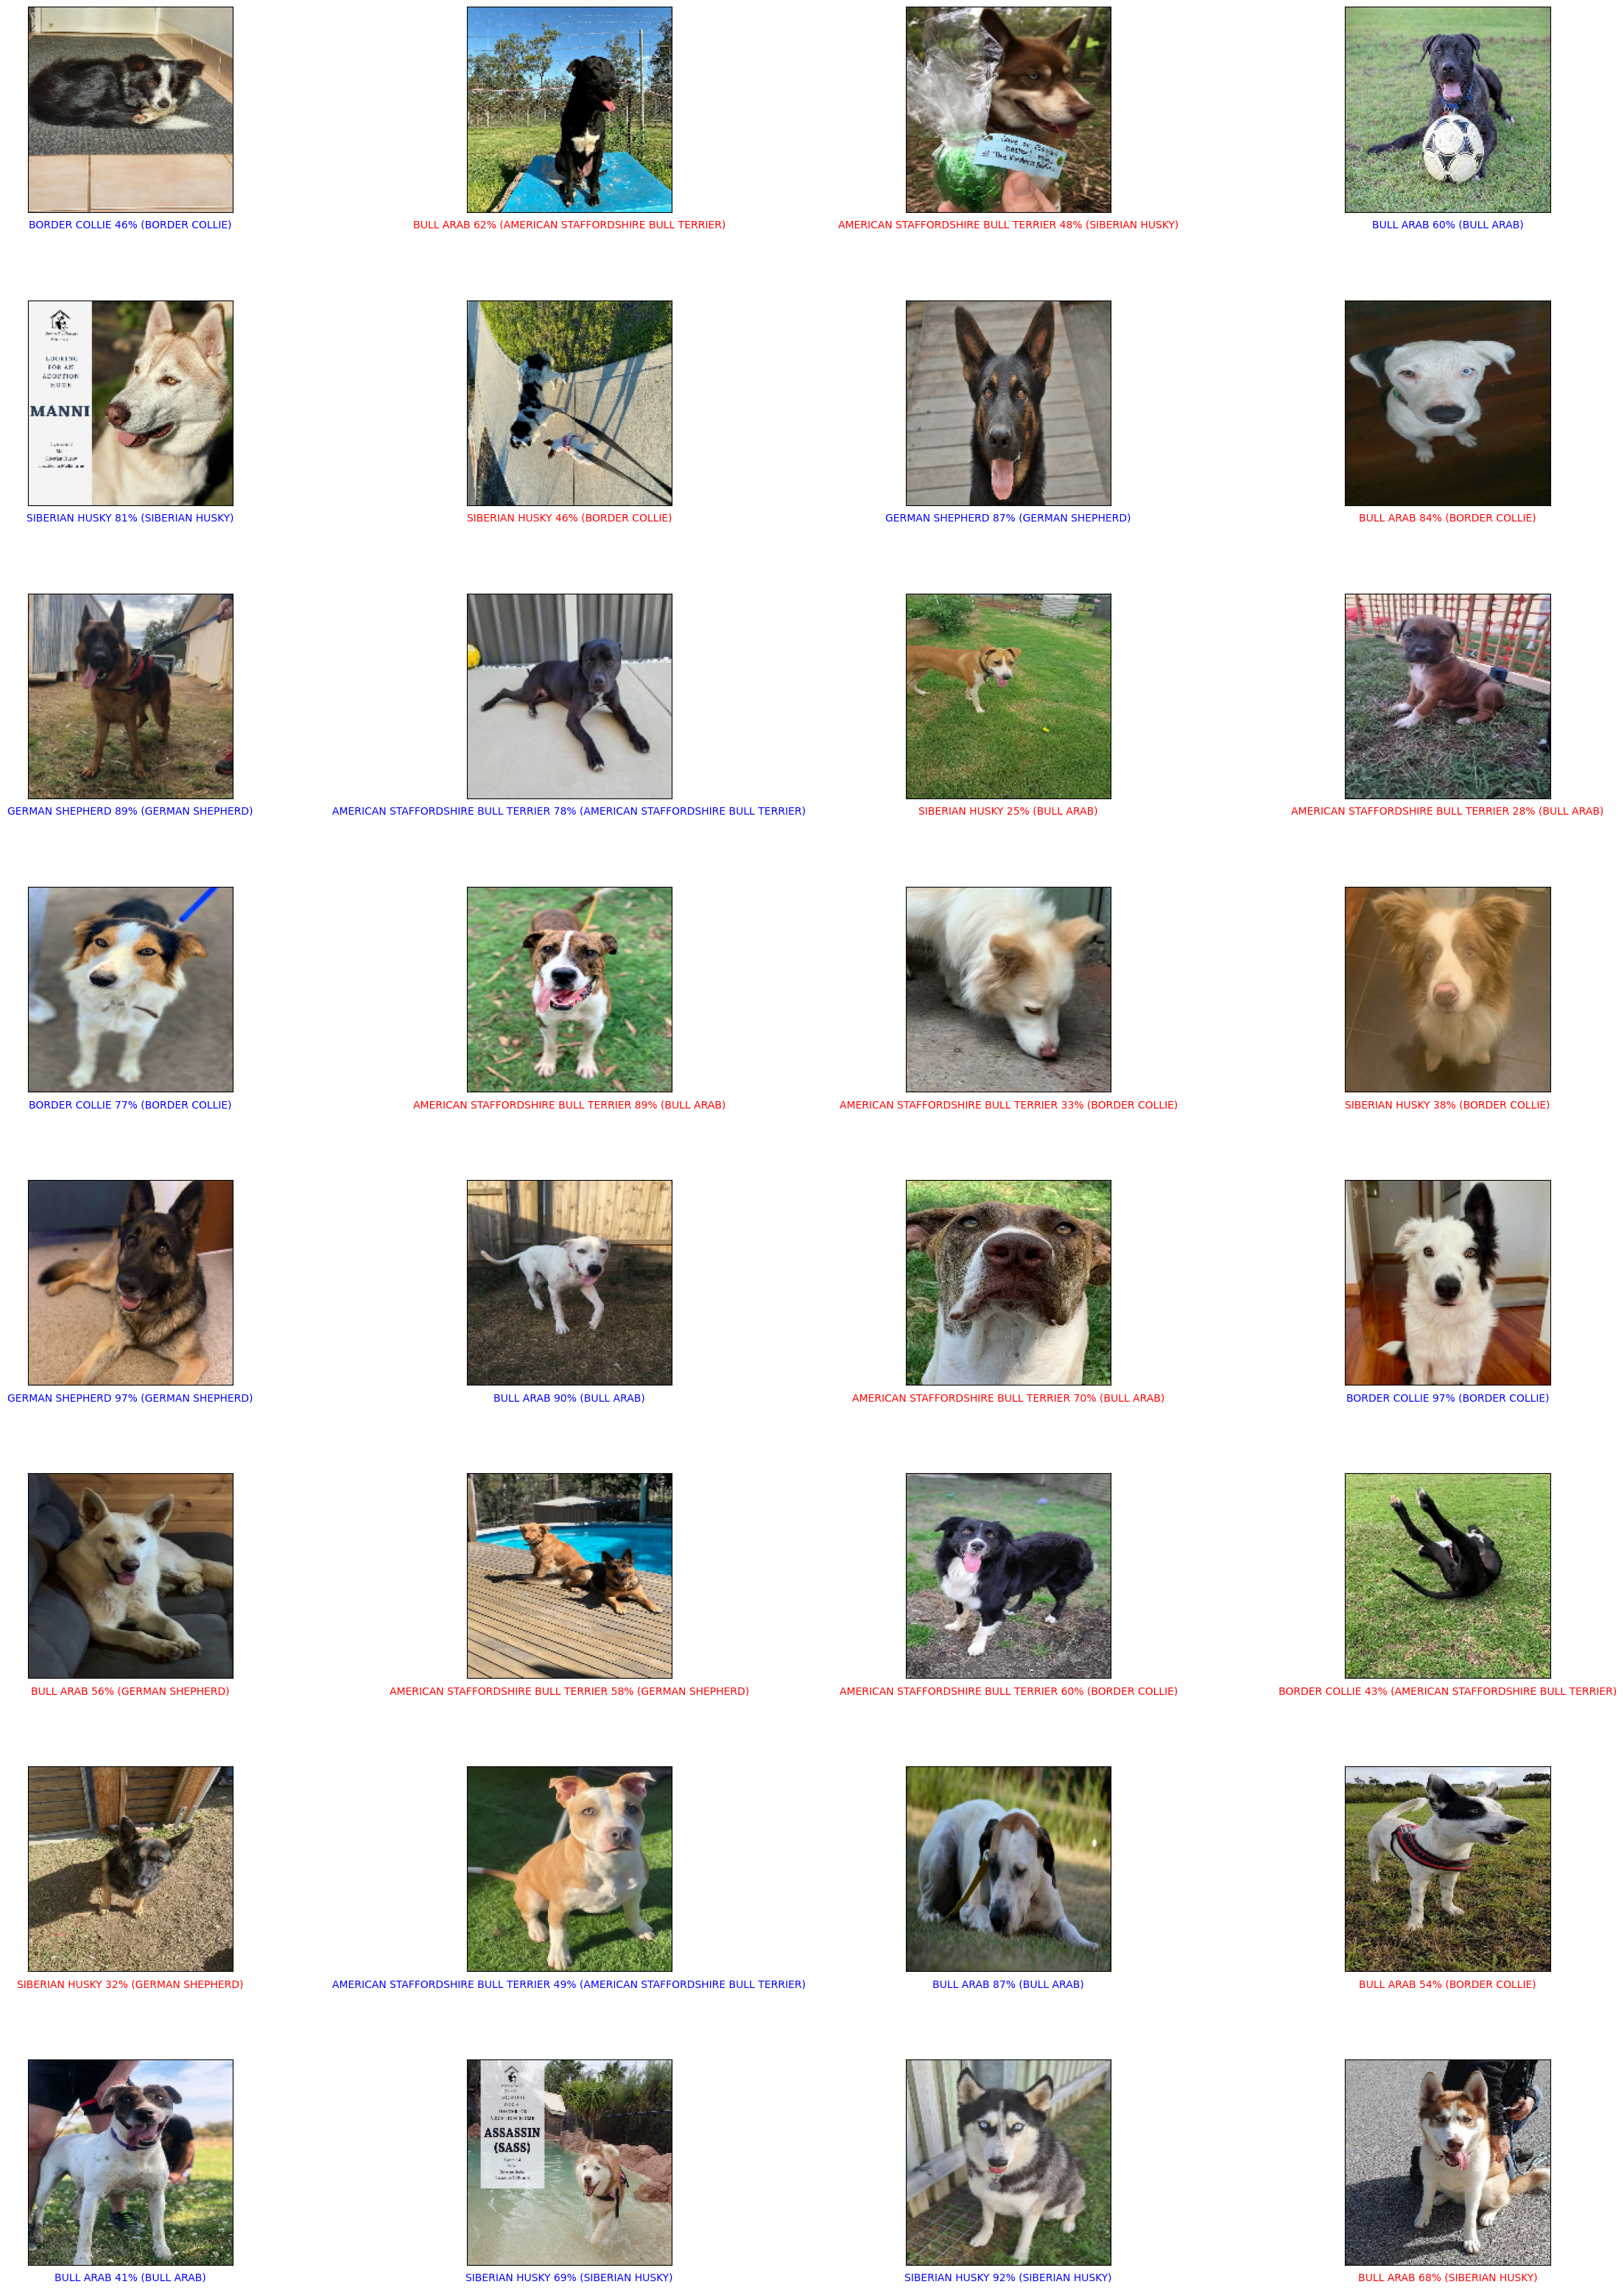

In [238]:
num_rows = 8
num_cols = 4
num_images = num_rows * num_cols
plt.figure(figsize=(6 * num_cols, 4 * num_rows))

for images, labels in test_ds.take(1):
    predictions = model.predict(images)
    for i, prediction in enumerate(predictions):
        plt.subplot(num_rows,2 * num_cols, 2 * i + 1)
        plot_image(tf.nn.softmax(prediction), labels[i], images[i])
plt.tight_layout()
plt.show()